# PSF Extractor
---

#### Overview
1. Initialize parameters
2. Create stack
3. Find features
4. Mass-based filtering
5. Filter out overlapping features
6. Extract PSFs
7. Filter out strange PSFs

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## 1) Initialize parameters
Trackpy takes expected feature diameters in ($z$, $y$, $x$) as input. Requires input diameters to be odd and recommends rounding up.

In [3]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set optical parameters:
NA = 0.85  # numerical aperture
lambda_em = 520  #emission wavelength

# Set expected feature diameters [nm]
dx_nm = 0.5 * lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3*dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Output
out = f"""\
Optical settings
----------------
NA............ {NA:.2f}
Wavelength.... {lambda_em:.0f} nm
Pixelsize x... {psx:.1f} nm/px
Pixelsize y... {psy:.1f} nm/px
Pixelsize z... {psz:.1f} nm/px
Diameter x.... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y.... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z.... {dz:.0f} px ({dz_nm:.1f} nm)
"""
print(out)

Optical settings
----------------
NA............ 0.85
Wavelength.... 520 nm
Pixelsize x... 64.0 nm/px
Pixelsize y... 64.0 nm/px
Pixelsize z... 125.0 nm/px
Diameter x.... 5 px (305.9 nm)
Diameter y.... 5 px (305.9 nm)
Diameter z.... 9 px (917.6 nm)



#### Spicy colormap

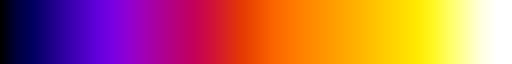

In [4]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

In [5]:
import trackpy
from psf_extractor import load_stack, plot_mip

## 2) Create stack

In [6]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = load_stack(file_pattern)

INFO:root:Creating stack from directory.


  0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:(32, 2048, 2448) image stack created succesfully.


## 3) Find features
---
The first step in the workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the image stack and expected feature diameters as input. No constraints are provided to `trackpy.locate` such that it returns all possible features on the scale of the expected feature dimensions. We then go through a series of filtering steps to end up with a feature set that ought to be single PSF localizations.

### Maximum intensity projection in `z`

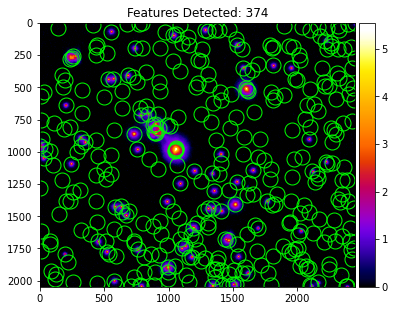

In [7]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
df_features = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)
N_features = len(df_features)

# Plot MIP
plot_mip(mip, features=df_features)

## 4) Mass-based filtering

The mass is the "integrated brightness" of a feature. It is important to choose reasonable lower and upper bounds to filter out spurious features (salt) smaller than the PSF and clusters larger than the PSF. It's difficult to know these bounds _a priori_, as the appropriate bounds will vary from dataset to dataset. So it is useful to sample a logarithmic range of candidate bounds and choose proper minimum and maximum masses based on visual inspection.

In [8]:
from ipywidgets import interact, fixed, FloatLogSlider
from psf_extractor import get_min_masses, get_max_masses, plot_mass_range_interactive

#### Choose minimum mass

In [9]:
# Choose minimum mass range
min_masses = get_min_masses(mip, dx=dx, n=35, b=20)

# Interactive plot
widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(min_masses),
                                      min=np.log10(min_masses.min()),
                                      max=np.log10(min_masses.max())),
                  features=fixed(df_features),
                  filtering=fixed('min'));

interactive(children=(FloatLogSlider(value=2.4639943838277563, description='mass', max=1.6926697092718745, min…

In [10]:
# Set minimum mass
min_mass = widget.widget.children[0].value

# Filter out dim features
df_min = df_features.loc[df_features['raw_mass'] > min_mass]

#### Choose maximum mass

In [11]:
# Get candidate minimum masses
max_masses = get_max_masses(min_mass, b=20, n=31)

widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(max_masses),
                                      min=np.log10(max_masses.min()),
                                      max=np.log10(max_masses.max())),
                  features=fixed(df_min),
                  filtering=fixed('max'));

interactive(children=(FloatLogSlider(value=11.019317876833144, description='mass', max=1.6926697092718745, min…

In [12]:
# Set minimum mass
max_mass = widget.widget.children[0].value
# Filter out super bright features
df_max = df_min.loc[df_min['raw_mass'] < max_mass]
# Update feature set
df_features = df_max.reset_index(drop=True)

# Output
out = f"""\
Minimum mass.................. {min_mass:.2f}
Maximum mass.................. {max_mass:.2f}
Detected features (initial)... {N_features:.0f}
Too dim (min filtered)........ {N_features-len(df_min):.0f}
Too bright (max filtered)..... {len(df_min)-len(df_max):.0f}
Remaining features............ {len(df_features):.0f}
Random sample of features.....
"""
print(out)
df_features.sample(5)

Minimum mass.................. 2.46
Maximum mass.................. 11.02
Detected features (initial)... 374
Too dim (min filtered)........ 305
Too bright (max filtered)..... 4
Remaining features............ 65
Random sample of features.....



,y,x,mass,size,ecc,signal,raw_mass,ep
8,347.140625,1578.930208,0.446844,1.364734,0.134003,0.047012,4.227451,0.004147
62,2027.912977,1500.970992,0.304878,1.391358,0.098684,0.029324,3.015687,0.005846
41,1424.070668,633.008712,0.480822,1.383067,0.103343,0.048408,4.650980,0.003764
23,957.689944,2.027933,0.166635,1.238354,0.231393,0.029790,5.427451,0.003220
64,2042.013685,787.052786,0.476168,1.388403,0.085525,0.046081,4.439216,0.003946


## 5) Filter out overlapping features

Overlapping PSFs must be removed so that they do not distort the PSF characterization. To remove them, a virtual bounding box is created around each feature and checked for overlap against every other feature's bounding box.

In [13]:
from psf_extractor import remove_overlapping_features, plot_overlapping_features

In [14]:
# Set dimensions of bounding box based on expected feature diameter
wx = 10*dx_nm/psx  # px
wy = 10*dy_nm/psy  # px

# Remove overlapping features
N_features = len(df_features)
df, overlapping = remove_overlapping_features(df_features, wx=wx, wy=wy, return_indices=True)

  0%|          | 0/2080 [00:00<?, ?it/s]

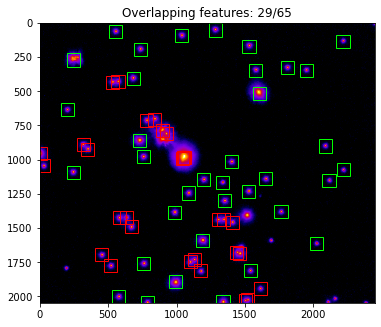

In [15]:
plot_overlapping_features(mip, df_features, overlapping, width=wx)

In [16]:
# Update feature set
df_features = df.reset_index(drop=True)

# Output
out = f"""\
Detected features (initial)... {N_features:.0f}
Overlapping features.......... {overlapping.size:.0f}
Remaining features............ {len(df_features):.0f}
Random sample of features.....
"""
print(out)
df_features.sample(5)

Detected features (initial)... 65
Overlapping features.......... 29
Remaining features............ 36
Random sample of features.....



,y,x,mass,size,ecc,signal,raw_mass,ep
32,1894.085784,992.141667,0.949543,1.392205,0.093380,0.093092,10.654902,0.001631
14,900.954491,2085.924551,0.388661,1.352310,0.088004,0.044219,3.549020,0.004953
9,348.885976,1947.091743,0.355148,1.367570,0.143702,0.037702,3.372549,0.005217
20,1145.933870,1199.037534,0.520852,1.369266,0.134967,0.054459,4.917647,0.003558
13,859.899557,729.102413,0.945353,1.375741,0.176594,0.098678,9.909804,0.001755


## 6) Extract PSFs
---

All of the filtered PSFs must be extracted before they can be aligned and averaged. We already have the rough coordinates of each PSF from filtering the features detected by `trackpy.locate`. So we simply define a subvolume containing the PSF and extract.

In [17]:
from psf_extractor import extract_psfs, plot_psfs

#### Define subvolume and extract PSFs

In [18]:
# Set dimensions of PSF subvolume based on expected feature diameter
wx = 5 * dx_nm/psx  # px
wy = 5 * dy_nm/psy  # px
wz = 3 * wx         # px
shape_psf = (wz, wy, wx)

# Extract PSFs
psfs, df = extract_psfs(stack, features=df_features, shape=shape_psf)

#### Plot the maximum intensity projection of each extracted PSF

  0%|          | 0/34 [00:00<?, ?it/s]

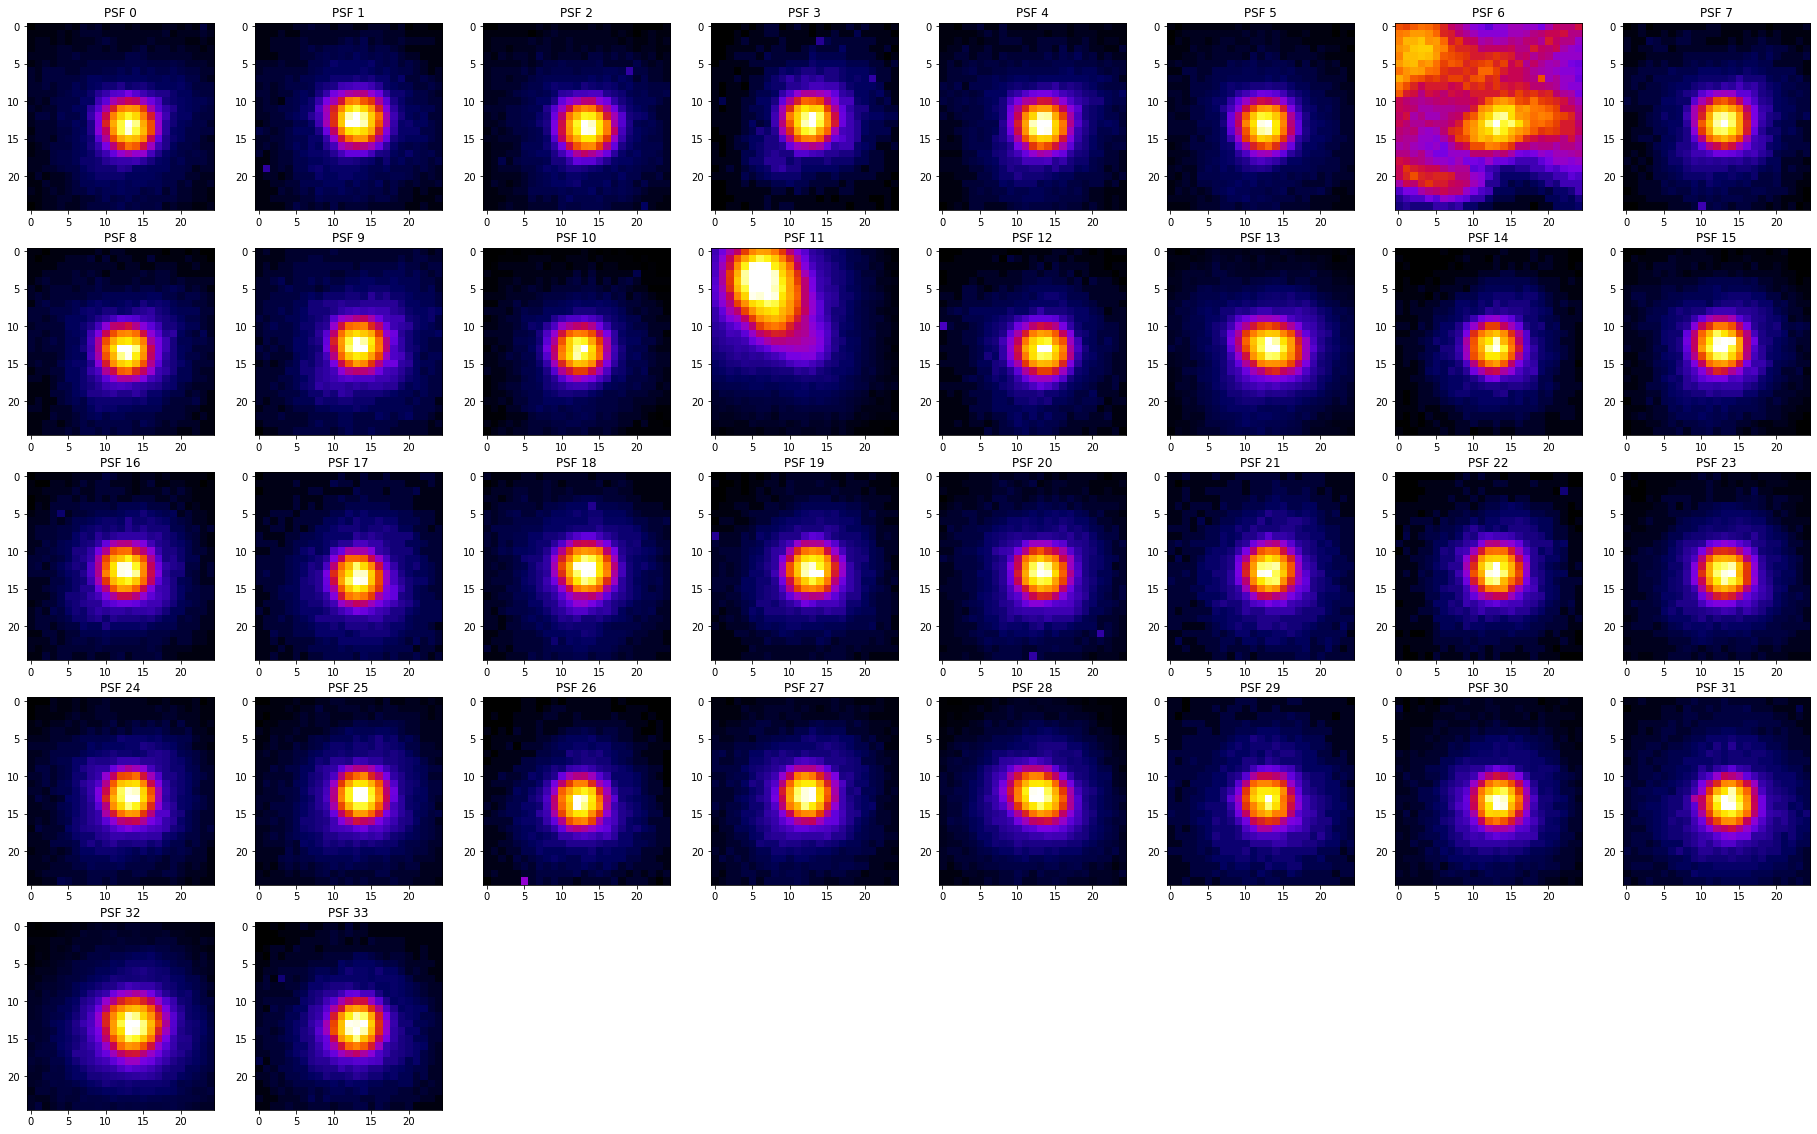

In [19]:
# Plot PSF MIPs
plot_psfs(psfs)

## 7) Filter out strange PSFs
Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls outside the acceptable range ($\mu_{PCC} \,\pm\, 3\sigma_{PCC}$).

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but 3× the average number of occurences seems to work empirically.

In [20]:
from psf_extractor import detect_outlier_psfs, plot_pcc_distribution

In [21]:
# Set minimum PCC threshold
pcc_min = 0.9

# Detect outlier PCCs
outliers, pccs = detect_outlier_psfs(psfs, pcc_min=pcc_min, return_pccs=True)

  0%|          | 0/561 [00:00<?, ?it/s]

#### Plot distribution of Pearson correlation coefficients

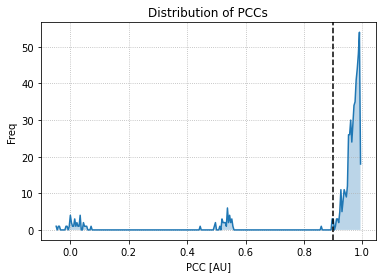

In [22]:
plot_pcc_distribution(pccs, pcc_min=pcc_min, bins=pccs.size//2)

In [24]:
# Update feature set
df_features = df_features.drop(index=outliers).reset_index(drop=True)

# Output
out = f"""\
Detected features (initial)... {len(psfs):.0f}
Outlier features.............. {outliers.size:.0f}
Remaining features............ {len(df_features):.0f}
Random sample of features.....
"""
print(out)
df_features.sample(5)

Detected features (initial)... 34
Outlier features.............. 2
Remaining features............ 32
Random sample of features.....



,y,x,mass,size,ecc,signal,raw_mass,ep
3,136.886115,2216.925117,0.298361,1.359659,0.109146,0.031186,2.780392,0.006352
10,900.954491,2085.924551,0.388661,1.352310,0.088004,0.044219,3.549020,0.004953
12,1016.882295,1402.904055,0.470582,1.365101,0.125000,0.049804,4.486275,0.003904
5,195.066977,735.882791,0.500372,1.370792,0.115340,0.052132,4.686275,0.003736
22,1380.115291,1763.876214,0.383541,1.363978,0.099034,0.041892,3.556863,0.004942


## 8) Localize PSFs

The individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. First, we fit a 2D Gaussian to each PSF in the maximum intensity projection to get the $x$, $y$ position. Then we fit a 1D Gaussian to the line profile through the center of the PSF to get the $z$ position.

* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [25]:
from scipy.optimize import curve_fit

from psf_extractor import (gaussian_1D, fit_gaussian_1D,
                           gaussian_2D, fit_gaussian_2D)

In [26]:
# Re-extract PSFs based on updated feature set
psfs, df_features = extract_psfs(stack, df_features, shape_psf)

In [27]:
def localize_psf():
    """Localize a given PSF in the stack."""
    pass

In [28]:
def localize_psfs():
    """Localize all PSFs in stack."""
    pass

In [32]:
from psf_extractor import fit_features_in_stack

In [33]:
fit_features_in_stack(stack, features=df_features)

INFO:root:Fitting slice (1/32)
INFO:root:Fitting slice (2/32)
INFO:root:Fitting slice (3/32)
INFO:root:Fitting slice (4/32)
INFO:root:Fitting slice (5/32)
INFO:root:Fitting slice (6/32)
INFO:root:Fitting slice (7/32)
INFO:root:Fitting slice (8/32)
INFO:root:Fitting slice (9/32)
INFO:root:Fitting slice (10/32)
INFO:root:Fitting slice (11/32)
INFO:root:Fitting slice (12/32)
INFO:root:Fitting slice (13/32)
INFO:root:Fitting slice (14/32)
INFO:root:Fitting slice (15/32)
INFO:root:Fitting slice (16/32)
INFO:root:Fitting slice (17/32)
INFO:root:Fitting slice (18/32)
INFO:root:Fitting slice (19/32)
INFO:root:Fitting slice (20/32)
INFO:root:Fitting slice (21/32)
INFO:root:Fitting slice (22/32)
INFO:root:Fitting slice (23/32)
INFO:root:Fitting slice (24/32)
INFO:root:Fitting slice (25/32)
INFO:root:Fitting slice (26/32)
INFO:root:Fitting slice (27/32)
INFO:root:Fitting slice (28/32)
INFO:root:Fitting slice (29/32)
INFO:root:Fitting slice (30/32)
INFO:root:Fitting slice (31/32)
INFO:root:Fitting

,x_0,y_0,sx_0,sy_0,A_0,B_0,x_1,y_1,sx_1,sy_1,...,sx_28,sy_28,A_28,B_28,x_29,y_29,sx_29,sy_29,A_29,B_29
0,3.483376e+00,7.667602e+00,1.143563,3.099648e+00,0.001053,3.025755e-03,4.614163e+00,1.219088e+01,6.397800,7.659287,...,0.307926,0.498187,0.031373,6.505841e-03,3.291438e+00,6.821827e+00,3.967020,2.983422,0.001794,2.205265e-03
1,3.859864e+00,8.118688e+00,10.192087,8.740772e+00,0.003990,1.160910e-12,2.128008e+00,6.655942e+00,3.349731,1.813260,...,0.441115,0.319000,0.023529,6.602852e-03,6.596320e+00,8.320077e+00,12.999993,5.614714,0.001678,1.818610e-03
2,5.897471e+00,7.523861e+00,7.679346,1.300000e+01,0.002252,1.794833e-03,7.165802e+00,5.214197e+00,0.899385,1.643125,...,5.856362,7.066115,0.007360,3.872867e-03,4.638603e-01,6.499180e+00,13.000000,2.918286,0.001342,3.156856e-03
3,5.788923e+00,9.915965e+00,3.913249,1.722381e+00,0.001593,3.723212e-03,1.300000e+01,6.134701e+00,2.864800,1.231029,...,2.630664,4.179279,0.004615,8.677663e-03,5.740511e+00,7.130803e+00,2.615777,0.669698,0.004359,4.105349e-03
4,4.213071e+00,6.292522e+00,1.622200,2.367094e+00,0.004121,4.683615e-03,5.986111e+00,1.003175e+01,3.199479,6.901190,...,3.019380,1.528434,0.008274,1.200221e-02,4.148033e-09,8.635953e+00,8.241033,4.790825,0.003154,3.575339e-03
5,8.071232e+00,1.126804e+01,4.012139,1.299999e+01,0.001232,4.290970e-03,2.995720e+00,5.401017e+00,1.656202,2.477323,...,3.362135,1.784186,0.007928,1.299324e-02,2.840550e+00,7.991786e+00,4.535935,4.229078,0.002150,4.418581e-03
6,8.520513e+00,9.899757e+00,0.918025,3.297966e+00,0.004155,6.919143e-03,4.639166e+00,4.961666e+00,5.701131,2.413331,...,2.623789,3.051941,0.015679,1.726736e-02,6.047119e+00,5.662999e+00,2.224857,2.402784,0.008089,6.042933e-03
7,6.203404e+00,7.189514e+00,4.334621,4.054709e+00,0.007446,4.563588e-03,5.818085e+00,6.493291e+00,2.637674,2.539566,...,11.825014,9.787201,0.035486,2.269519e-18,3.213631e+00,1.041957e+01,10.129924,9.980362,0.012408,1.418740e-20
8,7.499334e+00,8.469880e+00,4.645165,5.979288e+00,0.004359,8.345034e-03,7.462079e+00,5.661539e+00,2.711725,2.695862,...,3.445963,3.133189,0.048142,2.374761e-02,4.750107e+00,8.788446e+00,3.963665,3.318114,0.015830,7.650823e-03
9,6.529121e+00,1.066768e+01,7.082360,1.018301e+01,0.009547,4.470064e-03,5.521554e+00,6.294907e+00,10.554253,9.011097,...,3.227708,3.102029,0.062576,2.147879e-02,4.651611e+00,8.288903e+00,3.006908,2.681906,0.021722,8.676875e-03


In [29]:
# Initialize localization DataFrame
columns = ['x0', 'y0', 'z0', 'sigma_x', 'sigma_y', 'sigma_z']
df_loc = pd.DataFrame(columns=columns)

# Loop through PSFs
for i, psf in enumerate(psfs):

    # 2D Fit
    # ------
    # Take maximum intensity projection
    mip = np.max(psf, axis=0)
    x0, y0, sigma_x, sigma_y, A, B = fit_gaussian_2D(mip)

    # 1D Fit
    # ------
#     # Slice in through x0, y0
#     z_slice = psf[:,int(y0),int(x0)]
#     z0, sigma_z, A, B = fit_gaussian_1D(z_slice)
    # Integrate over x and y
    z_sum = psf.sum(axis=(1, 2))
    z0, sigma_z, A, B = fit_gaussian_1D(z_sum)
    # Populate DataFrame
    df_loc.loc[i, columns] = [x0, y0, z0, sigma_x, sigma_y, sigma_z]

# Preview DataFrame
df_loc.head()

,x0,y0,z0,sigma_x,sigma_y,sigma_z
0,13.116131,13.275107,15.256836,2.399313,2.38335,2.966986
1,13.059937,12.524112,15.439688,2.448634,2.359638,3.017461
2,13.327558,13.489146,15.286756,2.436169,2.361754,2.965116
3,12.700331,12.546496,14.848968,2.431338,2.340776,3.041769
4,13.278539,13.211494,15.097132,2.433392,2.377478,2.968748


#### Plot localization data

In [30]:
from psf_extractor import plot_psf_localizations

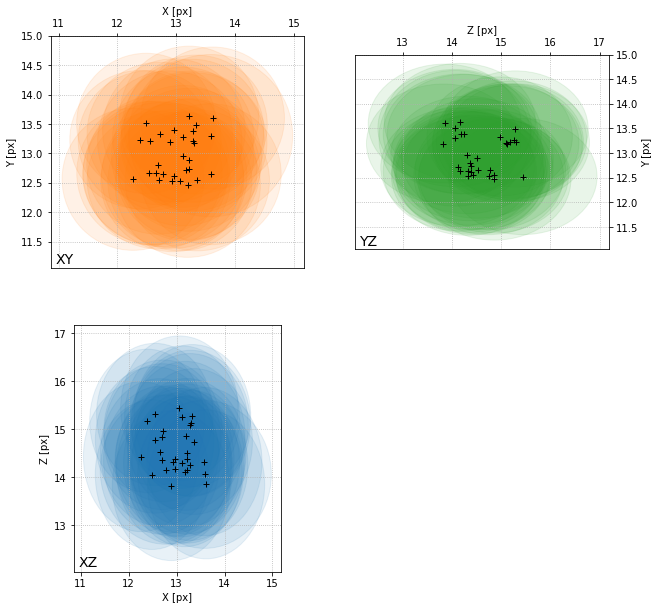

In [31]:
plot_psf_localizations(df_loc)

## Characterize PSF
---

#### Quick upsampling demo

In [ ]:
from skimage.transform import resize

In [ ]:
# Crop the central spot from a random psf
w = 20
i = np.random.randint(len(psfs))
Nz, Ny, Nx = psfs[i].shape
image = psfs[i][Nz//2,
                Ny//2-w//2: Ny//2+w//2,
                Nx//2-w//2: Nx//2+w//2].copy()

# Upsample with nearest-neighbor interpolation
image_k0 = resize(image, output_shape=(2*w, 2*w), order=0)
image_k1 = resize(image, output_shape=(2*w, 2*w), order=1)

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(image, cmap=fire)
axes[1].imshow(image_k0, cmap=fire)
axes[2].imshow(image_k1, cmap=fire)
# Aesthetics
axes[0].set_title('Original image')
axes[1].set_title('Nearest neighbor upsampling')
axes[2].set_title('Bi-linear upsampling');

### Upsample and align PSFs

In [ ]:
def align_psfs(psfs, locations, upsample_factor=2):
    """Upsample, align, and sum PSFs

    psfs : list or array-like
        List of PSFs
    locations : `pd.DataFrame`
        Localization data with z0, y0, and x0 positions

    Returns
    -------
    psf_sum : array-like
        Aligned and summed together PSFs
    """
    usf = upsample_factor
    psf_sum = 0
    for i, psf in tqdm(enumerate(psfs), total=len(psfs)):

        # Upsample PSFs
        psf_up = psfs[i].repeat(usf, axis=0)\
                        .repeat(usf, axis=1)\
                        .repeat(usf, axis=2)

        # From fit
        z0, y0, x0 = usf * df_loc.loc[i, ['z0', 'y0', 'x0']]
        # PSF center
        zc, yc, xc = (psf_up.shape[0]//2,
                      psf_up.shape[1]//2,
                      psf_up.shape[2]//2)

        # Multidimensional ~roll~
        dz, dy, dx = int(zc-z0), int(yc-y0), int(xc-x0)
        psf_up_a = np.roll(psf_up, shift=(dz, dy, dx), axis=(0, 1, 2))

        # Sum PSFs
        psf_sum += psf_up_a

    return psf_sum

In [ ]:
psf_sum = align_psfs(psfs, df_loc, upsample_factor=5)

In [ ]:
def crop_psf(psf):
    """"""
    # Get dimensions
    Nz, Ny, Nx = psf.shape
    Nmin = np.min([Nz, Ny, Nx])

    # Crop total psf to a cube defined by the smallest dimension
    z1, z2 = (Nz-Nmin)//2, Nz - ((Nz-Nmin)//2) - Nz % 2
    y1, y2 = (Ny-Nmin)//2, Ny - ((Ny-Nmin)//2) - Ny % 2
    x1, x2 = (Nx-Nmin)//2, Nx - ((Nx-Nmin)//2) - Nx % 2
    psf_cube = psf[z1:z2, y1:y2, x1:x2]

    return psf_cube

In [ ]:
def plot_psf(psf, crop=True):
    """"""

    # Create figure and axes
    fig = plt.figure(figsize=(11, 11))
    gs = fig.add_gridspec(6, 6)
    ax_xy = fig.add_subplot(gs[:3,:3])
    ax_yz = fig.add_subplot(gs[:3,3:])
    ax_xz = fig.add_subplot(gs[3:,:3])
    ax_z = fig.add_subplot(gs[-3,3:])
    ax_y = fig.add_subplot(gs[-2,3:])
    ax_x = fig.add_subplot(gs[-1,3:])

    # Crippity crop crop
    if crop:
        psf = crop_psf(psf)

    # PSF dimensions
    Nz, Ny, Nx = psf.shape
    # PSF volume
    dz, dy, dx = psz*Nz, psy*Ny, psx*Nx
    # PSF center coords
    z0, y0, x0 = Nz//2, Ny//2, Nx//2

    # Plot 2D PSFs (slices)
    ax_xy.imshow(psf[z0,:,:], cmap=fire)
    ax_yz.imshow(psf[:,y0,:], cmap=fire)
    ax_xz.imshow(psf[:,:,x0], cmap=fire)
    # 1D PSFs (slices)
    prof_z = psf[:,y0,x0]
    prof_y = psf[z0,:,x0]
    prof_x = psf[z0,y0,:]
    # Plot 1D PSFs
    plot_kwargs = {'ms': 5, 'marker': 'o', 'ls': '', 'alpha': 0.75}
    ax_z.plot(prof_z, c='C1', label='Z', **plot_kwargs)
    ax_y.plot(prof_y, c='C0', label='Y', **plot_kwargs)
    ax_x.plot(prof_x, c='C2', label='X', **plot_kwargs)

    # Do 1D PSF fits
    u = np.linspace(0, Nz, Ny*Nx)
    popt_z = fit_gaussian_1D(prof_z)
    popt_y = fit_gaussian_1D(prof_y)
    popt_x = fit_gaussian_1D(prof_x)

    # Plot 1D PSF fits
    ax_z.plot(u, gaussian_1D(u, *popt_z), 'k-',
              label=f'{popt_z[1]:.2f}nm\nFWHM')
    ax_y.plot(u, gaussian_1D(u, *popt_y), 'k-',
              label=f'{popt_y[1]:.2f}nm\nFWHM')
    ax_x.plot(u, gaussian_1D(u, *popt_x), 'k-',
              label=f'{popt_x[1]:.2f}nm\nFWHM')

    # Aesthetics
    [ax.legend(loc='upper right') for ax in [ax_z, ax_y, ax_x]]
    [ax.grid(ls=':') for ax in [ax_z, ax_y, ax_x]]
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [ ]:
plot_psf(psf_sum)

In [ ]:
output_shape = [n//5 for n in psf_sum.shape]
plot_psf(resize(psf, output_shape=output_shape, anti_aliasing=True))